<a href="https://colab.research.google.com/github/ziadtarek66/projects/blob/main/t5_text_summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libaraies**

In [1]:
# Ensure the necessary libraries are installed
!pip install -U transformers
!pip install -U datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Unin

In [2]:
# imports
import torch
import pprint
import evaluate
import numpy as np
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset

pp = pprint.PrettyPrinter()


# **Data Preprocessing**

In [3]:
# Prepare Dataset
dataset = load_dataset('gopalkalpande/bbc-news-summary', split='train')
full_dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
dataset_train = full_dataset['train']
dataset_valid = full_dataset['test']

print(dataset_train)
print(dataset_valid)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2224 [00:00<?, ? examples/s]

Dataset({
    features: ['File_path', 'Articles', 'Summaries'],
    num_rows: 1779
})
Dataset({
    features: ['File_path', 'Articles', 'Summaries'],
    num_rows: 445
})


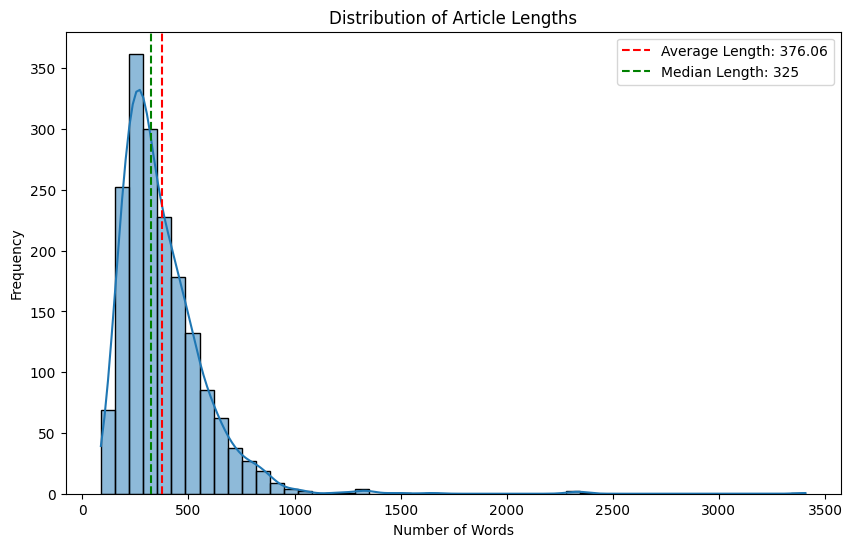

Maximum Article length: 3408 words
Minimum Article length: 87 words
Average Article length: 376.06 words
Median Article length: 325 words



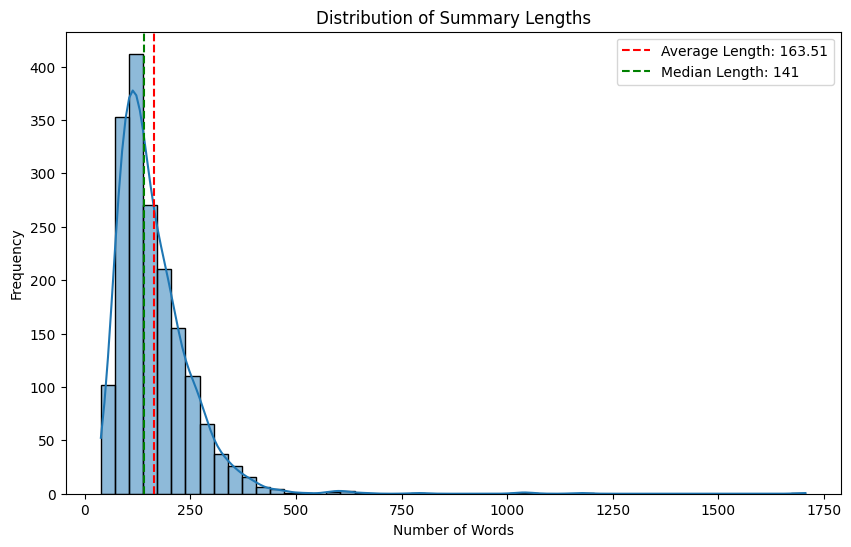

Maximum Summary length: 1706 words
Minimum Summary length: 38 words
Average Summary length: 163.51 words
Median Summary length: 141 words



In [4]:
# Dataset Analysis Functions
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_text_lengths(dataset, text_type, bins=50):
    lengths = [len(text.split()) for text in dataset]

    # Basic statistics
    max_length = max(lengths)
    min_length = min(lengths)
    avg_length = sum(lengths) / len(lengths)
    median_length = sorted(lengths)[len(lengths) // 2]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=bins, kde=True)
    plt.title(f'Distribution of {text_type} Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.axvline(x=avg_length, color='red', linestyle='--', label=f'Average Length: {avg_length:.2f}')
    plt.axvline(x=median_length, color='green', linestyle='--', label=f'Median Length: {median_length}')
    plt.legend()
    plt.show()

    # Print statistics
    print(f"Maximum {text_type} length: {max_length} words")
    print(f"Minimum {text_type} length: {min_length} words")
    print(f"Average {text_type} length: {avg_length:.2f} words")
    print(f"Median {text_type} length: {median_length} words")
    print()

# Analyze article lengths
analyze_text_lengths(dataset_train['Articles'], 'Article')

# Analyze summary lengths
analyze_text_lengths(dataset_train['Summaries'], 'Summary')


# **Building The Model**

In [5]:
# Configurations
MODEL = 't5-base'
BATCH_SIZE = 4
NUM_PROCS = 4
EPOCHS = 1
OUT_DIR = 'results_t5base'
MAX_LENGTH = 512

# Tokenization
tokenizer = T5Tokenizer.from_pretrained(MODEL)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Function to convert text data into model inputs and targets
def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['Articles']]
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding='max_length')
    targets = [summary for summary in examples['Summaries']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_LENGTH, truncation=True, padding='max_length')
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the function to the whole dataset
tokenized_train = dataset_train.map(preprocess_function, batched=True, num_proc=NUM_PROCS)
tokenized_valid = dataset_valid.map(preprocess_function, batched=True, num_proc=NUM_PROCS)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1779 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword ar

Map (num_proc=4):   0%|          | 0/445 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [7]:
# Define the configuration for the T5 model
config = T5Config(
    vocab_size = 32128,  # typical vocab size for T5
    d_model = 512,  # size of the embeddings
    d_ff = 2048,  # size of the feed-forward layer
    d_kv = 64,  # size of the key and value projection per attention head
    num_heads = 8,  # number of attention heads
    num_layers = 6,  # number of layers in the encoder and decoder
    dropout_rate = 0.1,  # dropout rate
    layer_norm_epsilon = 1e-6,  # epsilon for layer normalization
)

# Initialize the model from scratch
model = T5ForConditionalGeneration(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


60,506,624 total parameters.
60,506,624 training parameters.


In [8]:
# ROUGE Metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
        predictions = np.array(predictions[0])  # Assuming the first element of the tuple is the predictions array

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Now you can safely compute the ROUGE metric
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}


In [9]:
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels


In [10]:
model.config.decoder_start_token_id = tokenizer.pad_token_id

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir=OUT_DIR,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps = 200,
    save_strategy = 'epoch',
    save_total_limit = 2,
    report_to='tensorboard',
    learning_rate = 0.0001,
    dataloader_num_workers = 2
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Train the model
trainer.train()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
200,4.154000,3.898102,0.157900,0.001200,0.150500,0.150600,231.815700
400,3.589200,3.648507,0.218400,0.016100,0.177100,0.177200,231.818000


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TrainOutput(global_step=445, training_loss=4.063037004363671, metrics={'train_runtime': 11255.6004, 'train_samples_per_second': 0.158, 'train_steps_per_second': 0.04, 'total_flos': 240773064818688.0, 'train_loss': 4.063037004363671, 'epoch': 1.0})

In [12]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.6170201301574707, 'eval_rouge1': 0.2029, 'eval_rouge2': 0.012, 'eval_rougeL': 0.174, 'eval_rougeLsum': 0.1741, 'eval_gen_len': 231.818, 'eval_runtime': 761.8498, 'eval_samples_per_second': 0.584, 'eval_steps_per_second': 0.147, 'epoch': 1.0}


In [13]:
# Save the model
model.save_pretrained(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)


('results_t5base/tokenizer_config.json',
 'results_t5base/special_tokens_map.json',
 'results_t5base/spiece.model',
 'results_t5base/added_tokens.json')

# **Inference Data**

In [20]:
# Download inference data
!wget "https://www.dropbox.com/scl/fi/561r8pfhem4lu70hf438q/inference_data.zip?rlkey=aedt2saqmmp3a67qc4o34k04y&dl=1" -O inference_data.zip
!unzip inference_data.zip

--2024-07-01 20:13:59--  https://www.dropbox.com/scl/fi/561r8pfhem4lu70hf438q/inference_data.zip?rlkey=aedt2saqmmp3a67qc4o34k04y&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc448aec5635347809c68ac2160e.dl.dropboxusercontent.com/cd/0/inline/CV4dIXJTuEVbiPfaOA4ZXw7LjHvMkLg1_1ICECQjEMzAGMglNzfjA4sGSoJFUMrQdVlrFFZq9KFkupfTp1b2PCOZAKhcVwHXEaIZom56DJL3Ygwr3H3exIxUnW84pJiybfJ2GDJVkabAuMwIlP0WRSXu/file?dl=1# [following]
--2024-07-01 20:14:00--  https://uc448aec5635347809c68ac2160e.dl.dropboxusercontent.com/cd/0/inline/CV4dIXJTuEVbiPfaOA4ZXw7LjHvMkLg1_1ICECQjEMzAGMglNzfjA4sGSoJFUMrQdVlrFFZq9KFkupfTp1b2PCOZAKhcVwHXEaIZom56DJL3Ygwr3H3exIxUnW84pJiybfJ2GDJVkabAuMwIlP0WRSXu/file?dl=1
Resolving uc448aec5635347809c68ac2160e.dl.dropboxusercontent.com (uc448aec5635347809c68ac2160e.dl.dropboxusercontent.com)...

In [24]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = 't5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Set the decoder_start_token_id and bos_token_id
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.cls_token_id
if model.config.bos_token_id is None:
    model.config.bos_token_id = tokenizer.bos_token_id

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [25]:
def summarize_text(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [26]:
import glob
import pprint as pp

for file_path in glob.glob('inference_data/*.txt'):
    with open(file_path) as file:
        text = file.read()
        summary = summarize_text(text, model, tokenizer)
        pp.pprint(summary)
        print('-' * 75)

('the artificial intelligence industry was shaken by tectonic shifts over the '
 'weekend. Sam Altman — the leader of one of the world’s most influential AI '
 'companies, OpenAI — was fired by the startup’s board in a surprise move. the '
 'debacle unfolded just over a week after OpenAI held its first-ever developer '
 'conference.')
---------------------------------------------------------------------------
('Emmett Shear, the former CEO of Amazon’s streaming service Twitch, will join '
 'OpenAI as interim CEO. “We look forward to getting to know Emmett Shear,” '
 'Microsoft CEO Satya Nadella said in a post on X, formerly known as Twitter. '
 '“And we look forward to getting to know Emmett Shear,” Nadella said.')
---------------------------------------------------------------------------
